In [ ]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [2]:
def make_HWP_transfer_matrix(thicks,thetas,no,ne,wavelength):
    ## this code caculats the transfer matrix assumng x-y input and output
    ################
    ## thick --- the thickness of each layer, use mm
    ## theta --- the angle of the ordinary axis relative to the x axis
    ## no    --- the index along the ordinary axis
    ## ne    --- the index along the extrodinary axis
    ## wavelength  --- the wavelenght, use mm
    ################
    # set up the input layer, assumed to be vacuume
    TF = np.matrix([[1,0],
                    [0,1]])
    theta_prev = 0.
    # now iterate through the layers of HWP
    N_layers = np.size(thicks)
    i = 0
    while (i < N_layers):
        d_th = thetas[i] - theta_prev
        Mrot = np.matrix([[np.cos(d_th),np.sin(d_th)],
                         [-np.sin(d_th),np.cos(d_th)]])
        k = 2 * np.pi / wavelength
        phi_o = k * no * thicks[i]
        phi_e = k * ne * thicks[i]
        Mphase = np.matrix([[np.exp(np.complex(0,1)*phi_o),0],
                         [0, np.exp(np.complex(0,1)*phi_e)]])
        TF_layer = np.matmul(Mphase,Mrot)
        TF = np.matmul(TF_layer,TF)
        ## now iterate
        theta_prev = thetas[i]
        i+=1
    # now do the last layer
    d_th = 0 - theta_prev
    Mrot = np.matrix([[np.cos(d_th),np.sin(d_th)],
                      [-np.sin(d_th),np.cos(d_th)]])
    TF = np.matmul(Mrot,TF)
    return(TF)

##########
wavelength = 2.
no = 3
ne = 3.1
thicks = np.array([1/(ne-no)*wavelength/2.])
thetas = np.array([np.pi/4.])


print(thicks)
print(thetas)

tmp = make_HWP_transfer_matrix(thicks,thetas,no,ne,wavelength)

print("the transfer matrix")
print(tmp)
print("checking unitatity")
print(np.matmul(np.conj(tmp),tmp))

print(tmp[0,0])
print(tmp[1,0])   

In [3]:
def rotate_HWP(TF,psi):
    Mrot = np.matrix([[np.cos(psi),np.sin(psi)],
                      [-np.sin(psi),np.cos(psi)]])
    out = np.matmul(TF,Mrot)
    out = np.matmul(np.transpose(Mrot),out)
    return(out)


In [4]:
def sim_rot_HWP(TF,nsamps):
    angs = np.arange(nsamps)/nsamps * 2 * np.pi
    Ex_out = np.zeros(nsamps) * np.complex(0,1)
    Ey_out = np.zeros(nsamps) * np.complex(0,1)
    i = 0
    while(i<nsamps):
        TF_tmp = rotate_HWP(TF,angs[i])
        Ex_out[i] = TF_tmp[0,0]
        Ey_out[i] = TF_tmp[1,0]
        i+=1
    return(angs,Ex_out,Ey_out)

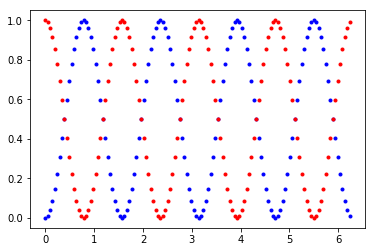

[3.33333333]


In [5]:
## setup a HWP for 2 mm
wavelength = 2.
no = 3.05
ne = 3.35
thicks = np.array([1/(ne-no)*wavelength/2.])
thetas = np.array([np.pi/4.])



## make the transfer funciton
wavelength = 2.
TF = make_HWP_transfer_matrix(thicks,thetas,no,ne,wavelength)

# simulate its output vs angle for x poliazed input
n_angles = 128
angs,Exo,Eyo = sim_rot_HWP(TF,n_angles)

## plot the results
plt.plot(angs,(np.abs(Exo))**2,"b.")
plt.plot(angs,(np.abs(Eyo))**2,"r.")
plt.show()

print(thicks)

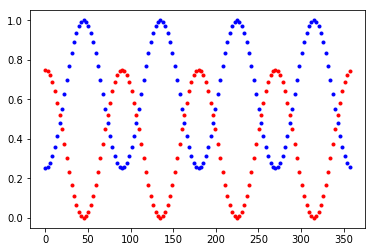

[ 3.75000000e-01+0.00000000e+00j -2.58158612e-17+1.60768989e-17j
 -4.03767227e-17-1.31022784e-17j -3.35645003e-17-6.25840893e-18j
  1.87500000e-01+2.85362012e-16j  2.90777807e-17+9.98593750e-18j
  7.02341155e-18-9.14254992e-19j  1.06868768e-17+1.02286366e-17j]
[ 1.23569707e-17-1.30203285e-18j  1.06868768e-17-1.02286366e-17j
  7.02341155e-18+9.14254992e-19j  2.90777807e-17-9.98593750e-18j
  1.87500000e-01+1.61329283e-16j -3.35645003e-17+6.25840893e-18j
 -4.03767227e-17+1.31022784e-17j -2.58158612e-17-1.60768989e-17j]
1.0


In [6]:
## make the transfer funciton
wavelength = 3.0
TF = make_HWP_transfer_matrix(thicks,thetas,no,ne,wavelength)

# simulate its output vs angle for x poliazed input
n_angles = 128
angs,Exo,Eyo = sim_rot_HWP(TF,n_angles)

## plot the results
plt.plot(angs*180/np.pi,(np.abs(Exo))**2,"b.")
plt.plot(angs*180/np.pi,(np.abs(Eyo))**2,"r.")
plt.show()



## fit fourier modes to the output

tmp = ( np.fft.ifft((np.abs(Eyo))**2))

print(tmp[0:8])
print(tmp[-8:])

print(2*np.abs(tmp[4])/np.abs(tmp[0]))




In [7]:
def mod_eff_and_phase(E):
    tmp = np.fft.ifft((np.abs(E))**2)
    mod_eff = 2. * np.abs(tmp[4]) /.5 #/ np.abs(tmp[0])
    ##
    tmp = np.arctan2(np.imag(tmp[4]),np.real(tmp[4]))
    phase =  45 + 180/np.pi * tmp/4.
    return(mod_eff,phase)

print(mod_eff_and_phase(Exo))

(0.7500000000000007, 2.842170943040401e-14)


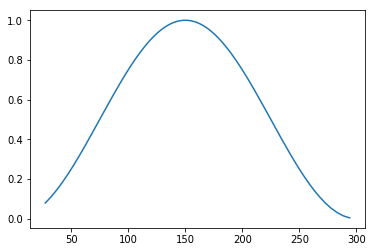

In [8]:
## wavelenght range
wavelengths = ((np.arange(0,500)+1)/500.)*10. + 1
freq_GHZ = 1./wavelengths * 300./1.  ## 
mod_effs = np.zeros(np.shape(wavelengths))
phases =   np.zeros(np.shape(wavelengths))

## numer of angles to use in the simulations of the HWP
n_angles = 32

## setup a HWP for 2 mm
wavelength = 2.
no = 3.05
ne = 3.35
thicks = np.array([1/(ne-no)*wavelength/2.])
thetas = np.array([np.pi/4.])



## make the transfer funciton
i = 0
while (i < np.size(wavelengths)):
    wavelength = wavelengths[i]
    TF = make_HWP_transfer_matrix(thicks,thetas,no,ne,wavelengths[i])
    angs,Exo,Eyo = sim_rot_HWP(TF,n_angles)
    mod_eff,phase = mod_eff_and_phase(Exo)
    mod_effs[i] = mod_eff
    phases[i] = phase
    i +=1


mod_effs_single = np.copy(mod_effs)
mod_phsses_single = np.copy(phases)

plt.plot(freq_GHZ,mod_effs_single) 
plt.show()


    
    

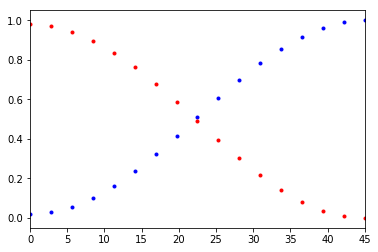

[ 4.89873243e-01+0.00000000e+00j -1.87136807e-17+1.68724832e-17j
 -6.95216274e-17-4.55285637e-19j -3.13424964e-17-2.96640732e-18j
  2.44936622e-01+3.54750951e-16j  4.57087354e-17-1.87979620e-18j
  5.66845454e-18+2.84595803e-17j  1.46170949e-17+1.92287114e-17j]


In [9]:
wavelength = 2.2
n_angles = 128

TF = make_HWP_transfer_matrix(thicks,thetas,no,ne,wavelength)
angs,Exo,Eyo = sim_rot_HWP(TF,n_angles)
mod_eff,phase = mod_eff_and_phase(Exo)


## plot the results
plt.plot(angs*180./np.pi,(np.abs(Exo))**2,"b.")
plt.plot(angs*180./np.pi,(np.abs(Eyo))**2,"r.")
plt.xlim(0,45)
plt.show()



## fit fourier modes to the output

tmp = ( np.fft.ifft((np.abs(Eyo))**2)[0:8])

print(tmp)

In [10]:
## compute the fraction of the simualted band that is usable, defined as above a threshold
#def fractional_BW_usable(mod_eff,thresshold):
#    ok = np.where(mod_eff > thresshold )
#    return(np.size(ok)/np.size(mod_eff))

def fractional_BW_usable(mod_eff):
    tmp = np.sum(mod_eff)
    tmp = tmp / np.size(mod_eff)
    return(tmp)

print(fractional_BW_usable(mod_effs_single))
print(fractional_BW_usable(mod_effs))


0.3566889860503669
0.3566889860503669


In [11]:
## calcuatle the dispersion in the phase angle
def phase_angle_dispersion(phase_angle,frequency):
    phase_angle  = np.unwrap(phase_angle*4.*np.pi/180)/4. * 180/np.pi
    #low_band = np.where(frequency  < 112.)
    #high_band =np.where(frequency > 122.)
    #out = np.std(phase_angle[low_band])
    #out += np.std(phase_angle[high_band])
    out = np.std(phase_angle)
    return(out)

#print(phase_angle_dispersion(mod_phsses_single))
#print(phase_angle_dispersion(phases))


In [12]:
def optomization_function(mod_effs,phase_angles,frequency):
    ## the bandwidth part, this is multiplitative, with small values being bad
    fBW = fractional_BW_usable(mod_effs)
    alpha = 0.05 ## smaller aphpah penalizes more for loss of BW
                ## 0.1 means 10% bw loss results in a 70% penalty
    BW_penalty = ( ((1-fBW)/alpha))
    ## the phase constancy part, small is good
    rms_phi = np.sqrt(phase_angle_dispersion(phase_angles,frequency)**2)
    ## optomization funciton should get small as things improe
    opt = rms_phi + BW_penalty ## consider addign a thickness penalty
    return(opt)

#print(optomization_function(mod_effs,phases))
#print(optomization_function(mod_effs_single,mod_phsses_single))

In [13]:
def evaluate_HWP(params):
    ##unpack the params
    thicks = np.abs(params[:int(np.size(params)/2)])
    thetas = params[int(np.size(params)/2):]*np.pi/180.
    ne = 3.2 + 0.31/2.
    no = 3.2 - 0.31/2.
    ## set up the wavelenght range
    freq_GHZ = np.arange(120) + 190.  ## from 70 to 170 GHz 
    #ok = np.where(np.logical_or(freq_GHZ < 112, freq_GHZ > 122))
    #freq_GHZ = freq_GHZ[ok]
    wavelengths = 1./freq_GHZ *300.  ## convert to mm
    ## set up the outputs for the calcaulation
    mod_effs = np.zeros(np.shape(wavelengths))
    phases =   np.zeros(np.shape(wavelengths))

    ## numer of angles to use in the simulations of the HWP
    n_angles = 32
    
    ## make the transfer funciton
    i = 0
    while (i < np.size(wavelengths)):
        wavelength = wavelengths[i]
        TF = make_HWP_transfer_matrix(thicks,thetas,no,ne,wavelengths[i])
        angs,Exo,Eyo = sim_rot_HWP(TF,n_angles)
        mod_eff,phase = mod_eff_and_phase(Exo)
        mod_effs[i] = mod_eff
        phases[i] = phase
        i +=1 
    
    phases  = np.unwrap(phases*4.*np.pi/180)/4. * 180/np.pi
    ## plots for debugging
    if (np.random.random_sample() < .002):  ## very important for speeding it up
        print("thicks: ", thicks)
        print("agnles: ", thetas*180./np.pi)
        plt.plot(freq_GHZ,mod_effs,"b.")
        plt.ylim(0,1)
        plt.show()
        plt.plot(freq_GHZ,phases-np.mean(phases),"r.")
        plt.show()

    return(optomization_function(mod_effs,phases,freq_GHZ))


freq_GHZ = np.arange(100) + 70.  ## from 70 to 170 GHz 

thicks = np.ones(5)* 1/(.3)*2./2.*1.4
angles = np.array([0,25,85,25,0])*np.pi/180.
params = np.concatenate((thicks,angles))
print(evaluate_HWP(params))

54.12038835777537


thicks:  [1.89013379 1.83092158 1.90040552 1.83092158 1.89013379]
agnles:  [ 2.28995060e+01 -5.00009221e+01 -3.03941004e-04  4.99993932e+01
 -2.29007311e+01]


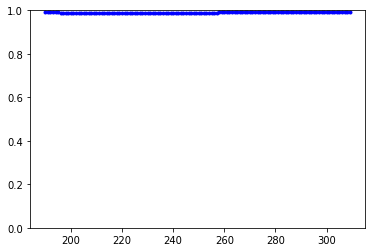

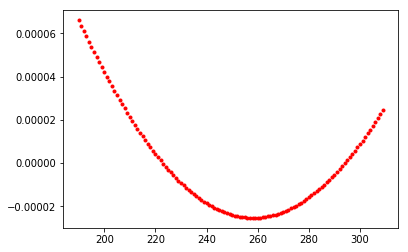

thicks:  [1.89991233 1.89938589 1.90000361 1.8993859  1.8999123 ]
agnles:  [ 2.28999956e+01 -5.00000082e+01 -2.70527186e-06  4.99999946e+01
 -2.29000065e+01]


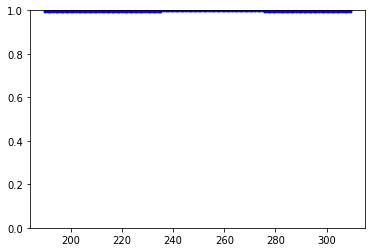

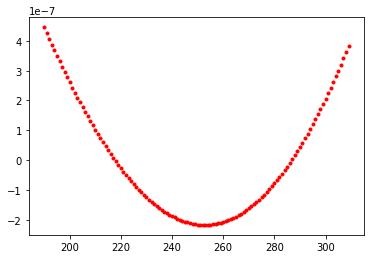

thicks:  [1.89936482 1.89939407 1.9035856  1.8993949  1.8993546 ]
agnles:  [ 2.29797262e+01 -5.01020800e+01  1.38290065e-03  5.01054134e+01
 -2.29763419e+01]


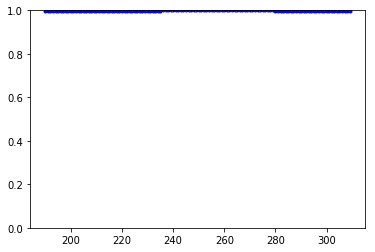

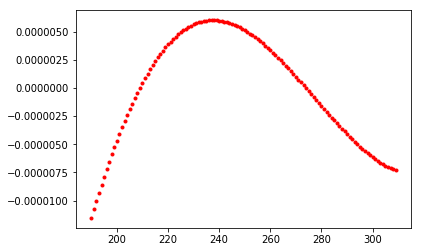

thicks:  [1.89995452 1.89937027 1.90076078 1.8993701  1.89994245]
agnles:  [ 2.36970868e+01 -5.10821140e+01  1.96386425e-02  5.10751118e+01
 -2.37164499e+01]


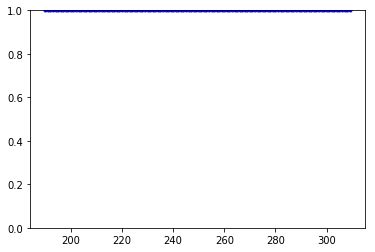

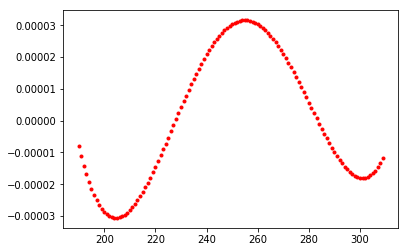

thicks:  [1.89988027 1.89937148 1.90122431 1.89937114 1.89987742]
agnles:  [ 2.37051564e+01 -5.11008256e+01  2.32041959e-02  5.10967893e+01
 -2.37222997e+01]


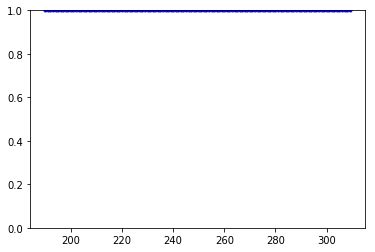

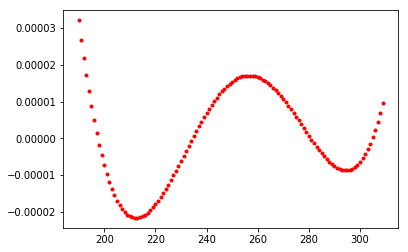

thicks:  [1.89995422 1.89935737 1.9010134  1.89935737 1.89996033]
agnles:  [ 2.32592539e+01 -5.14475153e+01  1.28094826e-03  5.14512692e+01
 -2.32551960e+01]


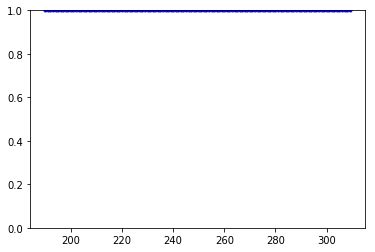

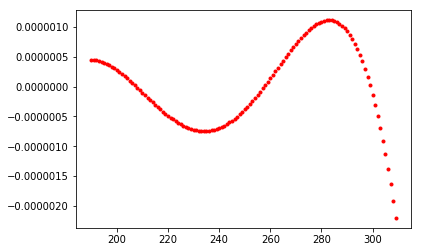

thicks:  [1.89995422 1.89935737 1.9010134  1.89935737 1.89996033]
agnles:  [ 2.32592539e+01 -5.14475153e+01  1.28093335e-03  5.14512692e+01
 -2.32551960e+01]


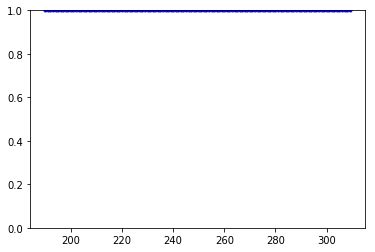

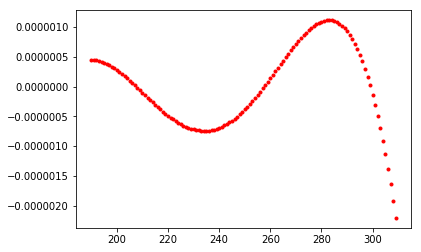

thicks:  [2.07053812 2.07225969 2.06913146 2.07222393 2.07129558]
agnles:  [ 22.76459745 -51.1675197   -0.19097204  50.51257774 -23.48552943]


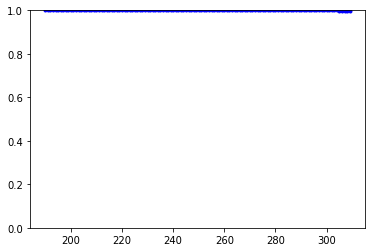

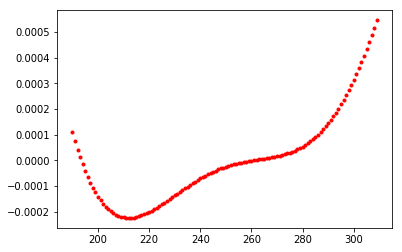

thicks:  [1.8697344  1.86826627 1.87293644 1.86827    1.86953201]
agnles:  [ 22.85641607 -51.26801509  -0.20904587  50.61933754 -23.56555016]


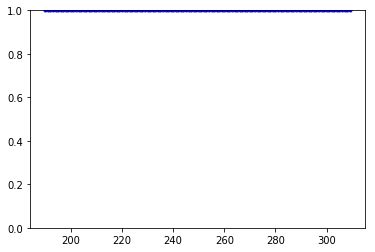

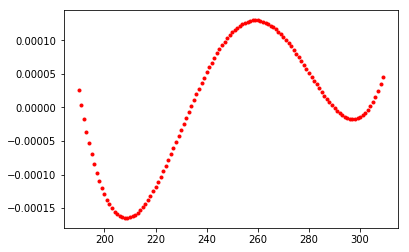

KeyboardInterrupt: 

In [14]:
params = np.array([ 1.9,  1.9 ,  1.9,  1.9 ,1.9,
                  22.9, -50, 0,  50,  -22.9])

tmp = opt.basinhopping(evaluate_HWP, params, niter=100, T=5.0, stepsize=1.0)
             
             
print(tmp)

[2. 2. 2. 2. 2.]
[ 23.2 -51.4   0.   51.4 -23.2]


/Users/jeffmcm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


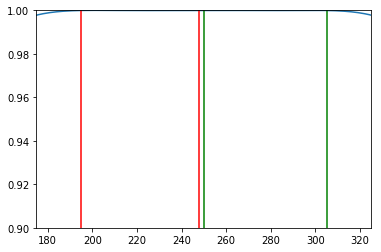

0.9999551706583251
0.9999551706583251


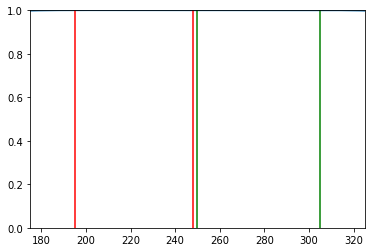

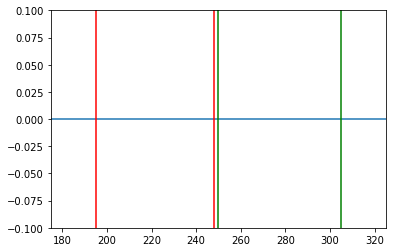

In [19]:
## fiducial SO design
no = 3.05
ne = 3.35
thick_HWP = 2.0
thicks = np.array([ 1,1,1,1,1])* thick_HWP 

psi_A = 23.2
psi_B = 51.4
thetas = np.array([psi_A, -psi_B, 0,  psi_B,  -psi_A])*np.pi/180. 

print(thicks)
print(thetas*180./np.pi)


## setup the sim
freq_GHZ = np.arange(600)  ## from 70 to 170 GHz 
wavelengths = 1./freq_GHZ *300.  ## convert to mm

mod_effs = np.zeros(np.shape(wavelengths))
phases = np.zeros(np.shape(wavelengths))

## make the transfer funciton
i = 0
while (i < np.size(wavelengths)):
    wavelength = wavelengths[i]
    TF = make_HWP_transfer_matrix(thicks,thetas,no,ne,wavelengths[i])
    angs,Exo,Eyo = sim_rot_HWP(TF,n_angles)
    mod_eff,phase = mod_eff_and_phase(Exo)
    mod_effs[i] = mod_eff
    phases[i] = phase
    i +=1



plt.plot(freq_GHZ,mod_effs) 
#plt.plot(freq_GHZ,mod_effs_single)
plt.ylim(0.9,1.0)
plt.xlim(175,325)
plt.plot(np.array([1,1])*195,np.array([0,1]),"r")
plt.plot(np.array([1,1])*248,np.array([0,1]),"r")
plt.plot(np.array([1,1])*250,np.array([0,1]),"g")
plt.plot(np.array([1,1])*305,np.array([0,1]),"g")
#plt.plot(np.array([1,1])*195,np.array([0,1]),"b")
#plt.plot(np.array([1,1])*250,np.array([0,1]),"b")
plt.show()

print(np.mean(mod_effs[np.where(np.logical_and(freq_GHZ>190,freq_GHZ<310))]))
print(np.mean(mod_effs[np.where(np.logical_and(freq_GHZ>190,freq_GHZ<310))]))

plt.plot(freq_GHZ,mod_effs) 
#plt.plot(freq_GHZ,mod_effs_single)
plt.ylim(0.0,1.0)
plt.xlim(175,325)
plt.plot(np.array([1,1])*195,np.array([0,1]),"r")
plt.plot(np.array([1,1])*248,np.array([0,1]),"r")
plt.plot(np.array([1,1])*250,np.array([0,1]),"g")
plt.plot(np.array([1,1])*305,np.array([0,1]),"g")
#plt.plot(np.array([1,1])*195,np.array([0,1]),"b")
#plt.plot(np.array([1,1])*250,np.array([0,1]),"b")
plt.show()




plt.plot(freq_GHZ,phases - np.mean(phases[50:150])) 
plt.xlim(175,325)
plt.ylim(np.array([-1,1])*0.1 )
plt.plot(np.array([1,1])*195,np.array([-1,1]),"r")
plt.plot(np.array([1,1])*248,np.array([-1,1]),"r")
plt.plot(np.array([1,1])*250,np.array([-1,1]),"g")
plt.plot(np.array([1,1])*305,np.array([-1,1]),"g")
plt.show()



#plt.plot(freq_GHZ,phases-np.mean(phases))

#phase_angle_s  = np.unwrap(mod_phsses_single*4.*np.pi/180)/4. * 180/np.pi

#plt.plot(freq_GHZ,phase_angle_s)
#plt.show() 

#plt.plot(freq_GHZ,phases)

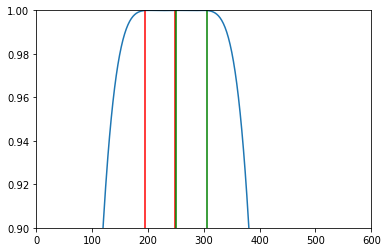

0.9999551706583251
0.9999551706583251


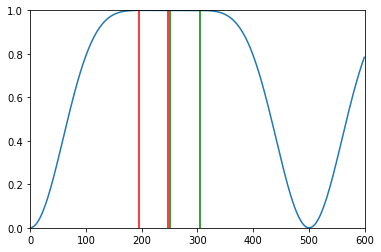

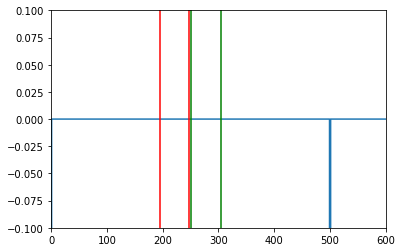

In [20]:


plt.plot(freq_GHZ,mod_effs) 
#plt.plot(freq_GHZ,mod_effs_single)
plt.ylim(0.9,1.0)
plt.xlim(0,600)
plt.plot(np.array([1,1])*195,np.array([0,1]),"r")
plt.plot(np.array([1,1])*248,np.array([0,1]),"r")
plt.plot(np.array([1,1])*250,np.array([0,1]),"g")
plt.plot(np.array([1,1])*305,np.array([0,1]),"g")
#plt.plot(np.array([1,1])*195,np.array([0,1]),"b")
#plt.plot(np.array([1,1])*250,np.array([0,1]),"b")
plt.show()

print(np.mean(mod_effs[np.where(np.logical_and(freq_GHZ>190,freq_GHZ<310))]))
print(np.mean(mod_effs[np.where(np.logical_and(freq_GHZ>190,freq_GHZ<310))]))

plt.plot(freq_GHZ,mod_effs) 
#plt.plot(freq_GHZ,mod_effs_single)
plt.ylim(0.0,1.0)
plt.xlim(0,600)
plt.plot(np.array([1,1])*195,np.array([0,1]),"r")
plt.plot(np.array([1,1])*248,np.array([0,1]),"r")
plt.plot(np.array([1,1])*250,np.array([0,1]),"g")
plt.plot(np.array([1,1])*305,np.array([0,1]),"g")
#plt.plot(np.array([1,1])*195,np.array([0,1]),"b")
#plt.plot(np.array([1,1])*250,np.array([0,1]),"b")
plt.show()




plt.plot(freq_GHZ,phases - np.mean(phases[50:150])) 
plt.xlim(0,600)
plt.ylim(np.array([-1,1])*0.1 )
plt.plot(np.array([1,1])*195,np.array([-1,1]),"r")
plt.plot(np.array([1,1])*248,np.array([-1,1]),"r")
plt.plot(np.array([1,1])*250,np.array([-1,1]),"g")
plt.plot(np.array([1,1])*305,np.array([-1,1]),"g")
plt.show()



